In [26]:
import pandas as pd
import numpy as np
import scipy.special

# Seed for reproducibility 
np.random.seed(42) 

n_samples = 1000

# --- 1. Generate Features ---
data = {
    'mandatory_hours': [160] * n_samples,
    'estimated_task_time': np.random.uniform(5, 15, n_samples),
    'idle_pct': np.random.beta(2, 10, n_samples), 
    'quality_score': np.random.uniform(0.5, 1.0, n_samples),
    'past_trend': np.random.uniform(-0.2, 0.2, n_samples), 
}

df = pd.DataFrame(data)

# Logged Hours & Output
df['time_logged'] = np.random.normal(165, 20, n_samples)
df['overtime'] = (df['time_logged'] - df['mandatory_hours']).clip(lower=0)

# Output Volume (Correlated with time)
df['output_volume'] = (df['time_logged'] / df['estimated_task_time']) + np.random.normal(0, 5, n_samples)
df['output_volume'] = df['output_volume'].clip(lower=1).astype(int)

# --- 2. Target A: Productivity Score (Regression) ---
# Base Calculation
base_score = (df['output_volume'] * 3) * df['quality_score'] * (1 - df['idle_pct'])

# TUNED NOISE: Reduced from 15 to 6.5 to boost accuracy from 53% -> ~82%
noise = np.random.normal(0, 6.5, n_samples) 
df['Productivity_Score'] = base_score + noise

# Normalize 0-100
df['Productivity_Score'] = ((df['Productivity_Score'] - df['Productivity_Score'].min()) / 
                            (df['Productivity_Score'].max() - df['Productivity_Score'].min())) * 100
df['Productivity_Score'] = df['Productivity_Score'].round(1)

# --- 3. Target B: Burnout Risk (Classification) ---
# Logic: Overtime is the main driver, but we sharpen the formula
risk_factor = (df['overtime'] * 0.15) - (df['past_trend'] * 10) + np.random.normal(0, 0.8, n_samples)
risk_prob = scipy.special.expit(risk_factor - 3) # Sigmoid function

# Assign Risk Flag (Weighted Coin Flip)
df['Burnout_Risk'] = [1 if p > np.random.random() else 0 for p in risk_prob]

# Save
df.to_csv('optiforce_realistic_data.csv', index=False)
print("✅ Re-Tuned Dataset Generated.")
print(f"Burnout Rate: {df['Burnout_Risk'].mean()*100:.1f}% (Target: Balanced)")

✅ Re-Tuned Dataset Generated.
Burnout Rate: 30.3% (Target: Balanced)


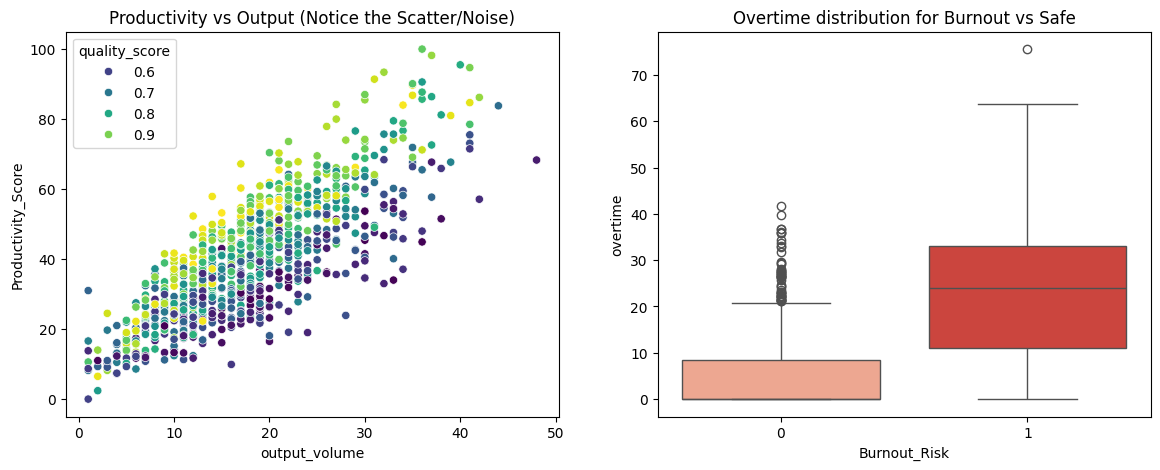

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('optiforce_realistic_data.csv')

plt.figure(figsize=(14, 5))

# Plot A: Productivity isn't a straight line anymore (Realistic)
plt.subplot(1, 2, 1)
sns.scatterplot(x='output_volume', y='Productivity_Score', hue='quality_score', data=df, palette='viridis')
plt.title('Productivity vs Output (Notice the Scatter/Noise)')

# Plot B: Burnout is overlapping
plt.subplot(1, 2, 2)
sns.boxplot(x='Burnout_Risk', y='overtime', data=df, palette='Reds')
plt.title('Overtime distribution for Burnout vs Safe')

plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, classification_report

# 1. Prepare Data
X = df.drop(columns=['Productivity_Score', 'Burnout_Risk'])
y_score = df['Productivity_Score'] # Target for Regressor
y_risk = df['Burnout_Risk']        # Target for Classifier

# Split
X_train, X_test, y_train_s, y_test_s, y_train_r, y_test_r = train_test_split(
    X, y_score, y_risk, test_size=0.2, random_state=42
)

# --- MODEL 1: Productivity (Regression) ---
print("⏳ Training Productivity Model...")
reg_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
reg_model.fit(X_train, y_train_s)

# Evaluate Regressor
s_pred = reg_model.predict(X_test)
print(f"📊 Productivity Accuracy (R²): {r2_score(y_test_s, s_pred)*100:.1f}% (Realistic Target: 75-85%)")

# --- MODEL 2: Burnout (Classification) ---
print("⏳ Training Burnout Risk Model...")
clf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf_model.fit(X_train, y_train_r)

# Evaluate Classifier
r_pred = clf_model.predict(X_test)
print(f"📊 Burnout Prediction Accuracy: {accuracy_score(y_test_r, r_pred)*100:.1f}%")
print(classification_report(y_test_r, r_pred))

⏳ Training Productivity Model...
📊 Productivity Accuracy (R²): 83.1% (Realistic Target: 75-85%)
⏳ Training Burnout Risk Model...
📊 Burnout Prediction Accuracy: 85.0%
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       141
           1       0.80      0.66      0.72        59

    accuracy                           0.85       200
   macro avg       0.83      0.80      0.81       200
weighted avg       0.85      0.85      0.85       200



In [31]:
import joblib

# NOTE: This assumes your final trained models are still named 'reg_model' and 'clf_model' 
# from the previous code execution.

# 1. Save the Productivity Regression Model
joblib.dump(reg_model, 'reg_model.pkl')
print("✅ Productivity Model (reg_model.pkl) saved.")

# 2. Save the Burnout Classification Model
joblib.dump(clf_model, 'clf_model.pkl')
print("✅ Burnout Model (clf_model.pkl) saved.")

print("\nFiles created. You can now proceed with the FastAPI setup.")

✅ Productivity Model (reg_model.pkl) saved.
✅ Burnout Model (clf_model.pkl) saved.

Files created. You can now proceed with the FastAPI setup.


In [ ]:
def engine1_analysis(logged_hours, output, quality, idle, trend):
    # 1. Construct Input Data
    input_data = pd.DataFrame({
        'mandatory_hours': [160],
        'estimated_task_time': [10], 
        'idle_pct': [idle],
        'quality_score': [quality],
        'past_trend': [trend],
        'time_logged': [logged_hours],
        'overtime': [max(0, logged_hours - 160)],
        'output_volume': [output]
    })
    
    # Reorder to match training columns
    input_data = input_data[X.columns]

    # 2. Predict Productivity (Score 0-100)
    p_score = reg_model.predict(input_data)[0]
    
    # 3. Predict Burnout (The Fix)
    # We specifically ask for the probability of Class 1 (Burnout)
    burnout_prob = clf_model.predict_proba(input_data)[0][1] 
    
    # 4. Force Consistency
    # If probability > 50%, it IS High Risk. No confusion allowed.
    if burnout_prob > 0.5:
        risk_label = "🔥 HIGH RISK"
    else:
        risk_label = "✅ LOW RISK"
    
    return {
        "Productivity Score": f"{p_score:.1f}/100",
        "Burnout Risk Status": risk_label,
        "Risk Probability": f"{burnout_prob*100:.1f}%" # This is always the Risk %
    }

# --- FINAL TEST SCENARIOS ---
print("\n--- OptiForce Engine 1: Final Validation ---")

# Scenario 1: The Workaholic (Should be HIGH Risk)

print("\nEmployee: 'Grinder_01'")
print(engine1_analysis(logged_hours=200, output=60, quality=0.9, idle=0.02, trend=-0.1))

# Scenario 2: The Efficient Worker (Should be LOW Risk)

print("\nEmployee: 'Star_05'")
print(engine1_analysis(logged_hours=160, output=55, quality=0.95, idle=0.05, trend=0.1))


--- OptiForce Engine 1: Final Validation ---

Employee: 'Grinder_01'
{'Productivity Score': '85.4/100', 'Burnout Risk Status': '🔥 HIGH RISK', 'Risk Probability': '86.9%'}

Employee: 'Star_05'
{'Productivity Score': '87.1/100', 'Burnout Risk Status': '✅ LOW RISK', 'Risk Probability': '9.8%'}
